# Variant Calling Report v1.1
## Input Parameters

In [67]:
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import numpy as np
from configparser import ConfigParser

pd.options.display.float_format = '{:,.2%}'.format

configFile='var_report.config'
parser = ConfigParser()
parser.read(configFile)

prmNames=['run_id',
          'h5_concordance_file', 'h5_model_file'
         ]

prm={}
for name in prmNames:
    prm[name]=parser.get('VarReport', name)

sources = {'Default':(prm['h5_concordance_file'],"concordance"),
           'Trained':(prm['h5_model_file'],"scored_concordance")
          }

data = {}
for s in sources:
    data[s]={}
    d=pd.read_hdf(sources[s][0], key=sources[s][1], mode='r')
    d=d[(d['close_to_hmer_run']==False) & (d['inside_hmer_run']==False)]
    data[s]=d

args=pd.read_hdf(sources['Default'][0], 'input_args', mode='r')
prm['truth_sample_name']=args['truth_sample_name'][0]
prmNames.append('truth_sample_name')

pd.DataFrame.from_dict(prm, orient='index',columns=['value']).reindex(prmNames)

,value
run_id,170201_BC23
h5_concordance_file,vcf_compare.BC23.h5
h5_model_file,vcf_compare.BC23.model.h5
truth_sample_name,HG002


In [68]:
def filterByCategory(data,cat):
    if cat=='SNP':
        return data[data['indel']==False]
    elif cat=='non-hmer Indel':
        return data[(data['indel']==True) & (data['hmer_indel_length']==0) & (data['indel_length']>0)]
    elif cat=='non-hmer Indel w/o LCR':
        return data[(data['indel']==True) & (data['hmer_indel_length']==0) & (data['indel_length']>0) & 
                    (~data['LCR-hs38'])]
    elif cat=='hmer Indel <=4':
        return data[(data['indel']==True) & (data['hmer_indel_length']>0) & (data['hmer_indel_length']<=4)]
    elif cat=='hmer Indel >4,<=8':
        return data[(data['indel']==True) & (data['hmer_indel_length']>4) & (data['hmer_indel_length']<=8)]
    elif cat=='hmer Indel >8,<=12':
        return data[(data['indel']==True) & (data['hmer_indel_length']>8) & (data['hmer_indel_length']<=12)]
    for i in range (1,10):
        if cat=='hmer Indel {0:d}'.format(i):
            return data[(data['indel']==True) & (data['hmer_indel_length']==i)]
    return None


In [69]:
def calcPerformance(data, gt=False):
    classify='classify_gt' if gt else 'classify'
    
    d=data.copy()
    d['tree_score'] = np.where(d[classify]=='fn',-1,d['tree_score'])
    d=d[[classify,'tree_score']].sort_values(by=['tree_score'])
    d['label'] = np.where(d[classify]=='fp',0,1)

    num=len(d)
    numPos=sum(d['label'])
    numNeg=num-numPos
    if num<10:
        return (pd.DataFrame(),None)
    
    d['fn']=np.cumsum(d['label'])
    d['tp']=numPos-(d['fn'])
    d['fp']=numNeg-np.cumsum(1-d['label'])

    d['recall']=d['tp']/(d['tp']+d['fn'])
    d['precision']=d['tp']/(d['tp']+d['fp'])

    d['f1']=d['tp']/(d['tp']+0.5*d['fn']+0.5*d['fp'])

    d['mask']=((d['tp']+d['fn'])>=20) & ((d['tp']+d['fp'])>=20) & (d['tree_score']>=0)
    maxF1=max(d[d['mask']]['f1'])
    d['opt']=(d['f1']==maxF1)

    return (d[['recall','precision']][d['mask']],
            d[['recall','precision','f1']][d['opt'] & d['mask']],
            numPos,numNeg)



In [70]:
def plotPerformance(perfCurve,optRes,categories,ext=None):
    n=len(categories)
    fig, ax = plt.subplots(1,n,figsize=(4*n,4))
    col=['r','b','g','m','k']

    for i,cat in enumerate(categories):
        for j,s in enumerate(sources):
            perf=perfCurve[s][cat]
            opt=optRes[s][cat]
            if not perf.empty:
                ax[i].plot(perf.recall,perf.precision,'-',label=s,color=col[j])    
                ax[i].plot(opt.recall,opt.precision,'o',color=col[j])
            title=cat if ext==None else '{0} ({1})'.format(cat,ext)
            ax[i].set_title(title)
            ax[i].set_xlabel("Recall")
            ax[i].set_xlim([0.4,1])
            ax[i].set_ylim([0.4,1])
            ax[i].grid(True)

    ax[0].set_ylabel("Precision")
    ax[0].legend(loc='lower left')
    
    
def getPerformance(data,categories,gt=False):
    optTab={}
    optRes={}
    perfCurve={}
    for s in sources:
        optTab[s]=pd.DataFrame()
        optRes[s]={}
        perfCurve[s]={}

        for i,cat in enumerate(categories):
            d=filterByCategory(data[s],cat)
            perf,opt,pos,neg=calcPerformance(d,gt)
            perfCurve[s][cat]=perf
            optRes[s][cat]=opt
            
            row=pd.DataFrame({'# pos':pos,
                              '# neg':neg,
                              'max recall':np.nan if perf.empty else max(perf.recall),
                              'recall':np.nan if perf.empty else opt.recall[0],
                              'precision':np.nan if perf.empty else opt.precision[0],
                              'F1':np.nan if perf.empty else opt.f1[0]
                             },index=[cat])
            optTab[s]=pd.concat([optTab[s],row])
            
    return optTab,optRes,perfCurve


## Performance: all Data

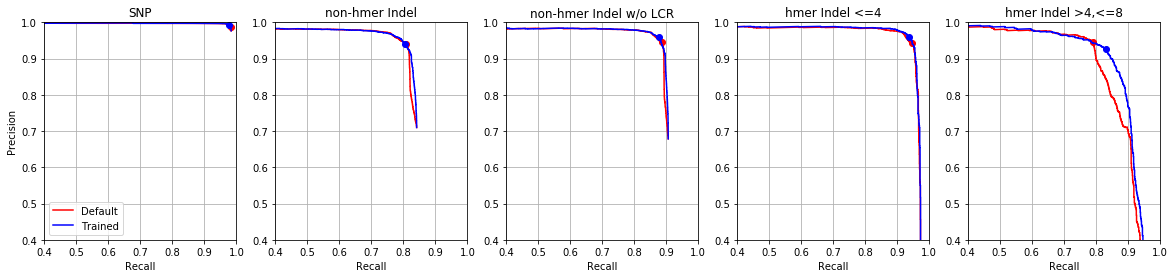

In [71]:
categories=['SNP','non-hmer Indel','non-hmer Indel w/o LCR','hmer Indel <=4','hmer Indel >4,<=8']
optTab1,optRes,perfCurve=getPerformance(data,categories)
plotPerformance(perfCurve,optRes,categories)

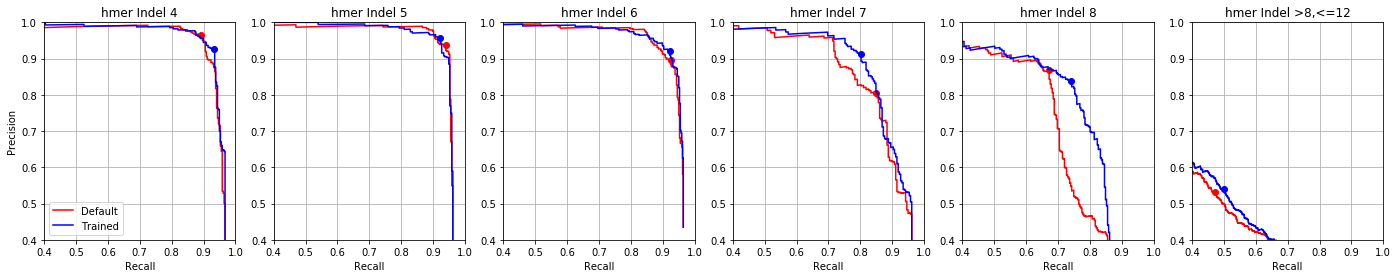

In [72]:
categories=['hmer Indel 4','hmer Indel 5','hmer Indel 6','hmer Indel 7','hmer Indel 8','hmer Indel >8,<=12']
optTab2,optRes,perfCurve=getPerformance(data,categories)
plotPerformance(perfCurve,optRes,categories)

In [73]:
pd.options.display.float_format = '{:,.2%}'.format

optTab={}
for s in sources:
    optTab[s]=pd.concat([optTab1[s], optTab2[s]])
pd.concat([optTab[s] for s in sources], axis=1, keys=[s for s in sources])

Default                                            \
                         # pos  # neg max recall recall precision     F1   
SNP                     130399   3063     98.34% 98.13%    98.83% 98.48%   
non-hmer Indel            8225   2830     84.18% 80.94%    94.13% 87.04%   
non-hmer Indel w/o LCR    5872   2521     90.63% 88.62%    94.48% 91.46%   
hmer Indel <=4            2037  23073     97.50% 94.75%    94.38% 94.56%   
hmer Indel >4,<=8         1309   3387     95.42% 79.07%    94.69% 86.18%   
hmer Indel 4               339   1557     96.76% 89.09%    96.49% 92.64%   
hmer Indel 5               315    698     96.19% 93.97%    93.67% 93.82%   
hmer Indel 6               425    534     96.47% 92.47%    89.73% 91.08%   
hmer Indel 7               258    382     96.12% 84.88%    80.51% 82.64%   
hmer Indel 8               311   1773     92.60% 67.20%    86.72% 75.72%   
hmer Indel >8,<=12         715   4186     93.01% 47.27%    53.23% 50.07%   

                       Trained                                            
                         # pos  # neg max recall recall precision     F1  
SNP                     130399   3063     98.34% 97.64%    99.33% 98.48%  
non-hmer Indel            8225   2830     84.18% 80.63%    93.98% 86.79%  
non-hmer Indel w/o LCR    5872   2521     90.63% 87.70%    95.85% 91.60%  
hmer Indel <=4            2037  23073     97.50% 93.86%    95.89% 94.86%  
hmer Indel >4,<=8         1309   3387     95.42% 83.04%    92.59% 87.56%  
hmer Indel 4               339   1557     96.76% 93.22%    92.67% 92.94%  
hmer Indel 5               315    698     96.19% 92.06%    95.71% 93.85%  
hmer Indel 6               425    534     96.47% 92.24%    92.02% 92.13%  
hmer Indel 7               258    382     96.12% 80.23%    91.19% 85.36%  
hmer Indel 8               311   1773     92.60% 73.95%    83.94% 78.63%  
hmer Indel >8,<=12         715   4186     93.15% 49.93%    54.01% 51.89%

### Including genotype

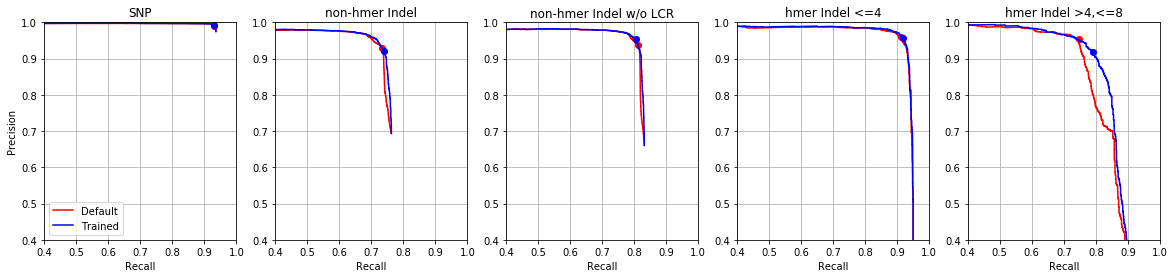

In [74]:
categories=['SNP','non-hmer Indel','non-hmer Indel w/o LCR','hmer Indel <=4','hmer Indel >4,<=8']
optTab,optRes,perfCurve=getPerformance(data,categories,gt=True)
plotPerformance(perfCurve,optRes,categories)

In [75]:
pd.concat([optTab[s] for s in sources], axis=1, keys=[s for s in sources])

Default                                            \
                         # pos  # neg max recall recall precision     F1   
SNP                     130318   3144     93.60% 93.09%    99.07% 95.99%   
non-hmer Indel            8267   2788     76.29% 73.40%    93.04% 82.06%   
non-hmer Indel w/o LCR    5880   2513     83.15% 81.17%    93.88% 87.07%   
hmer Indel <=4            2036  23074     95.19% 91.11%    96.06% 93.52%   
hmer Indel >4,<=8         1323   3373     90.40% 74.60%    95.45% 83.75%   

                       Trained                                            
                         # pos  # neg max recall recall precision     F1  
SNP                     130318   3144     93.60% 93.01%    99.15% 95.98%  
non-hmer Indel            8267   2788     76.30% 73.99%    92.03% 82.03%  
non-hmer Indel w/o LCR    5880   2513     83.16% 80.48%    95.35% 87.28%  
hmer Indel <=4            2036  23074     95.19% 91.75%    95.79% 93.73%  
hmer Indel >4,<=8         1323   3373     90.40% 79.14%    91.92% 85.05%

## Performance: cvg>=20, mappability.0

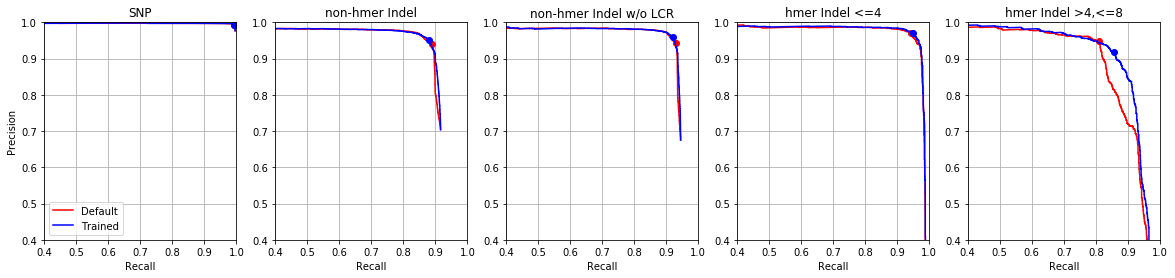

In [76]:
filtData={}
for s in sources:
    d=data[s]
    filtData[s]=d[(d['well_mapped_coverage']>=20) &
                  (d['mappability.0'])
                 ]

categories=['SNP','non-hmer Indel','non-hmer Indel w/o LCR','hmer Indel <=4','hmer Indel >4,<=8']
optTab1,optRes,perfCurve=getPerformance(filtData,categories)
plotPerformance(perfCurve,optRes,categories)


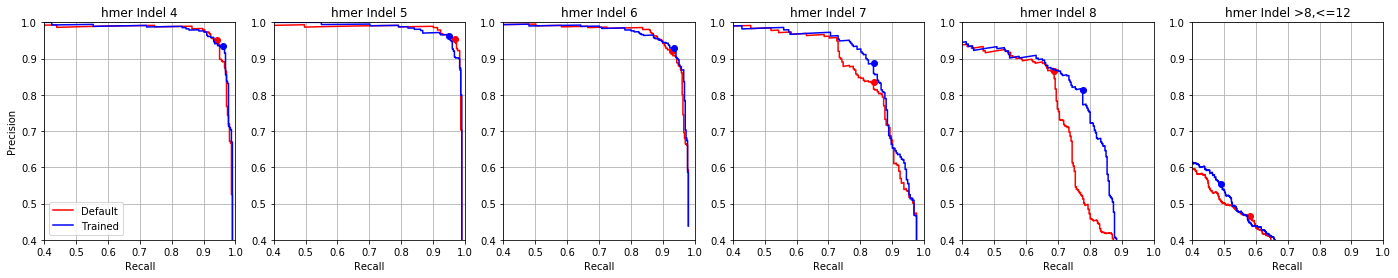

In [77]:
categories=['hmer Indel 4','hmer Indel 5','hmer Indel 6','hmer Indel 7','hmer Indel 8','hmer Indel >8,<=12']
optTab2,optRes,perfCurve=getPerformance(filtData,categories)
plotPerformance(perfCurve,optRes,categories)


In [78]:
optTab={}
for s in sources:
    optTab[s]=pd.concat([optTab1[s], optTab2[s]])
pd.concat([optTab[s] for s in sources], axis=1, keys=[s for s in sources])

Default                                            \
                         # pos  # neg max recall recall precision     F1   
SNP                     126168   2981     99.57% 99.18%    99.37% 99.28%   
non-hmer Indel            7096   2735     91.64% 88.84%    94.12% 91.40%   
non-hmer Indel w/o LCR    5411   2458     94.49% 92.98%    94.39% 93.68%   
hmer Indel <=4            1968  22883     98.98% 94.31%    96.97% 95.62%   
hmer Indel >4,<=8         1267   3350     97.32% 80.98%    94.74% 87.32%   
hmer Indel 4               323   1528     99.07% 94.12%    95.00% 94.56%   
hmer Indel 5               302    681     99.01% 97.02%    95.44% 96.22%   
hmer Indel 6               412    519     98.06% 92.96%    92.07% 92.51%   
hmer Indel 7               252    379     97.62% 84.13%    83.46% 83.79%   
hmer Indel 8               301   1771     94.35% 68.77%    86.61% 76.67%   
hmer Indel >8,<=12         695   4169     94.53% 58.13%    46.44% 51.63%   

                       Trained                                            
                         # pos  # neg max recall recall precision     F1  
SNP                     126168   2981     99.57% 99.17%    99.40% 99.29%  
non-hmer Indel            7096   2735     91.64% 87.89%    95.19% 91.40%  
non-hmer Indel w/o LCR    5411   2458     94.49% 92.11%    95.90% 93.97%  
hmer Indel <=4            1968  22883     98.98% 95.07%    97.04% 96.05%  
hmer Indel >4,<=8         1267   3350     97.32% 85.71%    91.80% 88.65%  
hmer Indel 4               323   1528     99.07% 95.98%    93.37% 94.66%  
hmer Indel 5               302    681     99.01% 95.03%    96.31% 95.67%  
hmer Indel 6               412    519     98.06% 93.69%    93.01% 93.35%  
hmer Indel 7               252    379     97.62% 84.13%    88.70% 86.35%  
hmer Indel 8               301   1771     94.35% 77.74%    81.25% 79.46%  
hmer Indel >8,<=12         695   4169     94.68% 49.06%    55.36% 52.02%

### Including genotype

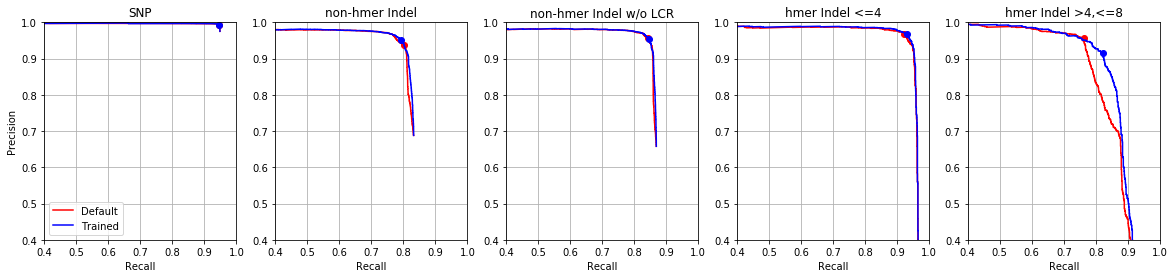

In [79]:
categories=['SNP','non-hmer Indel','non-hmer Indel w/o LCR','hmer Indel <=4','hmer Indel >4,<=8']
optTab,optRes,perfCurve=getPerformance(filtData,categories,gt=True)
plotPerformance(perfCurve,optRes,categories)

In [80]:
pd.concat([optTab[s] for s in sources], axis=1, keys=[s for s in sources])

Default                                            \
                         # pos  # neg max recall recall precision     F1   
SNP                     126121   3028     94.84% 94.47%    99.30% 96.82%   
non-hmer Indel            7137   2694     83.23% 80.34%    93.66% 86.49%   
non-hmer Indel w/o LCR    5420   2449     86.90% 84.30%    95.59% 89.59%   
hmer Indel <=4            1966  22885     96.69% 92.17%    96.85% 94.45%   
hmer Indel >4,<=8         1282   3335     92.20% 76.21%    95.60% 84.81%   

                       Trained                                            
                         # pos  # neg max recall recall precision     F1  
SNP                     126121   3028     94.84% 94.49%    99.30% 96.83%  
non-hmer Indel            7137   2694     83.24% 79.42%    95.24% 86.61%  
non-hmer Indel w/o LCR    5420   2449     86.92% 84.74%    95.45% 89.78%  
hmer Indel <=4            1966  22885     96.69% 93.13%    96.72% 94.90%  
hmer Indel >4,<=8         1282   3335     92.20% 82.06%    91.48% 86.51%

### per base

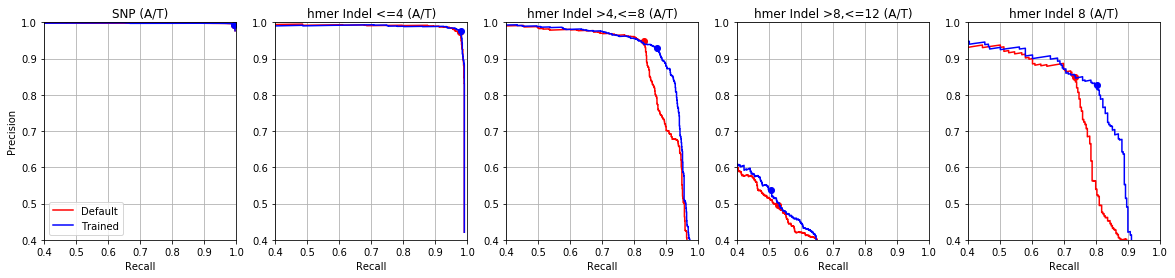

In [81]:
categories=['SNP','hmer Indel <=4','hmer Indel >4,<=8','hmer Indel >8,<=12','hmer Indel 8']

baseData={}
b =('A','T')
for s in sources:
        d=filtData[s]
        baseData[s]=d[((d['indel']==False) & ((d['ref']==b[0]) | (d['ref']==b[1]))) |
                      ((d['hmer_indel_length']>0) & ((d['hmer_indel_nuc']==b[0]) | (d['hmer_indel_nuc']==b[1])))
                     ]
optTab1,optRes,perfCurve=getPerformance(baseData,categories)
for s in sources:
    optTab1[s].rename(index={a:'{0} ({1}/{2})'.format(a,b[0],b[1]) for a in optTab1[s].index}, inplace=True)
plotPerformance(perfCurve,optRes,categories,'A/T')


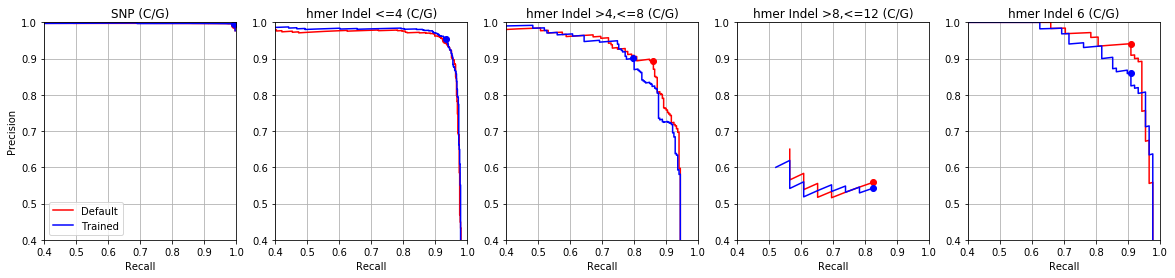

In [82]:
categories=['SNP','hmer Indel <=4','hmer Indel >4,<=8','hmer Indel >8,<=12','hmer Indel 6']
baseData={}
b =('C','G')
for s in sources:
        d=filtData[s]
        baseData[s]=d[((d['indel']==False) & ((d['ref']==b[0]) | (d['ref']==b[1]))) |
                      ((d['hmer_indel_length']>0) & ((d['hmer_indel_nuc']==b[0]) | (d['hmer_indel_nuc']==b[1])))
                     ]
optTab2,optRes,perfCurve=getPerformance(baseData,categories)
for s in sources:
    optTab2[s].rename(index={a:'{0} ({1}/{2})'.format(a,b[0],b[1]) for a in optTab2[s].index}, inplace=True)
plotPerformance(perfCurve,optRes,categories,'C/G')


In [83]:
optTab={}
for s in sources:
    optTab[s]=pd.concat([optTab1[s], optTab2[s]])
pd.concat([optTab[s] for s in sources], axis=1, keys=[s for s in sources])

Default                                            \
                           # pos  # neg max recall recall precision     F1   
SNP (A/T)                  59841   1417     99.56% 99.17%    99.40% 99.29%   
hmer Indel <=4 (A/T)        1261   1720     99.05% 97.54%    97.31% 97.43%   
hmer Indel >4,<=8 (A/T)     1017   2772     98.03% 82.99%    94.94% 88.56%   
hmer Indel >8,<=12 (A/T)     672   4152     94.94% 52.98%    49.65% 51.26%   
hmer Indel 8 (A/T)           269   1758     96.65% 73.61%    84.98% 78.88%   
SNP (C/G)                  66327   1562     99.58% 99.19%    99.35% 99.27%   
hmer Indel <=4 (C/G)         707  21163     98.87% 93.07%    95.09% 94.07%   
hmer Indel >4,<=8 (C/G)      250    578     94.40% 86.00%    89.21% 87.58%   
hmer Indel >8,<=12 (C/G)      23     17     82.61% 82.61%    55.88% 66.67%   
hmer Indel 6 (C/G)            88    206     97.73% 90.91%    94.12% 92.49%   

                         Trained                                            
                           # pos  # neg max recall recall precision     F1  
SNP (A/T)                  59841   1417     99.56% 99.24%    99.33% 99.29%  
hmer Indel <=4 (A/T)        1261   1720     99.05% 97.86%    97.70% 97.78%  
hmer Indel >4,<=8 (A/T)     1017   2772     98.03% 87.02%    92.86% 89.85%  
hmer Indel >8,<=12 (A/T)     672   4152     95.09% 50.74%    53.79% 52.22%  
hmer Indel 8 (A/T)           269   1758     96.65% 80.30%    82.76% 81.51%  
SNP (C/G)                  66327   1562     99.58% 99.14%    99.44% 99.29%  
hmer Indel <=4 (C/G)         707  21163     98.87% 93.35%    95.38% 94.35%  
hmer Indel >4,<=8 (C/G)      250    578     94.40% 79.60%    90.05% 84.50%  
hmer Indel >8,<=12 (C/G)      23     17     82.61% 82.61%    54.29% 65.52%  
hmer Indel 6 (C/G)            88    206     97.73% 90.91%    86.02% 88.40%